# Assignment 5, by Maksim Kaledin

This is a jupyter part of the report.

## Problem 7

The primal problem is

$$
\begin{split}
&\min_{x_1,x_2}2x_1^2+2x_2^2-x_1x_2,\quad s.t.\\
& \quad 2x_1+3x_2\geq 1,\\
& \quad 5x_1+4x_2 \geq 1.
\end{split}
$$

Let us represent this in matrix form:
$$
\begin{split}
&\min_{x_1,x_2}x^TQx,\quad s.t.\\
Ax \leq b,
\end{split}
$$
where 
$$
A=
\begin{bmatrix}
-2 & -3\\
-5 & -4
\end{bmatrix}, ~b=\begin{bmatrix}-1 \\ -1\end{bmatrix}, ~ 
Q=\begin{bmatrix}
2 & -1/2\\
-1/2 & 2
\end{bmatrix}.
$$

We can apply Sylvester's criterium to find out that quadratic form $Q$ is positive definite. First, let $L(x,\lambda)$ be a Lagrange function $L=x^TQx+\lambda^T(Ax-b)$, then stationarity conditions read

$$
\nabla_x L = (Q+Q^T)x+A^T\lambda =0 \Rightarrow x_*=-\frac{1}{2}Q^{-1}A^T\lambda.
$$
This gives us a solution to subproblem $\inf_x L$, so the dual problem is

$$
\begin{split}
&\max_{\lambda} \frac{1}{4}\lambda^TAQ^{-1}A^T\lambda - \lambda^Tb, ~ s.t.\\
&\lambda \geq 0.
\end{split}
$$

In [21]:
import cvxpy as cv
import numpy as np

In [81]:
x_primal = cv.Variable(2)

Q=np.array([[2,-1/2],[-1/2,2]])
A=np.array([[-2, -3],[-5, -4]])

b=np.array([-1,-1]).reshape(2,1)

p7obj_primal =cv.Minimize(cv.quad_form(x_primal,Q))

p7_primal = cv.Problem(p7obj_primal, [A*x_primal <= b])

p7_primal.solve()

print(p7_primal.status)
print(p7_primal.value)
print(x_primal.value)

optimal
0.1171874999741835
[[ 0.17187506]
 [ 0.21874996]]


In [96]:
x_dual = cv.Variable(2)

Q1=A.dot(np.linalg.inv(Q)).dot(A.T)
print(Q1)

p7obj_dual =cv.Maximize(1/4*cv.quad_form(x_dual,Q1)-b.reshape(1,2)*x_dual)

p7_dual = cv.Problem(p7obj_dual, [x_dual >=0])

p7_dual.solve()

print(p7_dual.status)
print(p7_dual.value)
print(x_dual.value)

[[  8.53333333  14.8       ]
 [ 14.8         27.2       ]]


DCPError: Problem does not follow DCP rules.

For some reason cvx recognize the problem as non-convex, but it obviously is.

## Problem 1

To handle censored data we can exploit the known information about lower bound: let us demand that predicted values for censored observations are bounded from below with $D$. The corresponding optimization problem is
$$
\begin{split}
&\min_{c^T} \sum_{i=1}^{M} (c^Tx_i-y_i)^2,\\
&s.t. \quad c^Tx_i>D \quad \text{for $i>M$},
\end{split}
$$
where $M$ is amount of known $y_i$, $x_i$ are input data vectors. 

In [1]:
import numpy as np #necessary imports
import cvxpy as cv
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
#Data generation
n=20
M=25
K=100

np.random.seed(1)
c_true = np.random.randn(n)
X=np.random.randn(n,K)
y=np.dot(X.T, c_true)+0.1*np.sqrt(n)*np.random.randn(K)
print(c_true.shape)

#Reorder
sort_ind=np.argsort(y)
X=X[:, sort_ind]
y=y[sort_ind[:M +1]]
D=(y[M-1]+y[M])/2
y=y[:M]
print(y.shape)

(20,)
(25,)


In [60]:
c_hat = cv.Variable(X.shape[0])

print(y.shape)
print(X[:,:M].T.shape)
print((X[:,:M].T*c_hat-y.reshape(M,1)).size)

censSq_constr = [X[:,M:].T*c_hat >= D*np.ones((K-M,1))]
censSq_problem = cv.Problem(cv.Minimize(cv.sum_squares(X[:,:M].T*c_hat-y.reshape(M,1))),censSq_constr)

censSq_problem.solve()

print(censSq_problem.status)
print(censSq_problem.value)
print(c_hat.value)

(25,)
(25, 20)
(25, 1)
optimal
2.0711948419902706
[[ 1.53817956]
 [-0.75310014]
 [-0.43716121]
 [-1.04458413]
 [ 0.87371472]
 [-2.28535139]
 [ 1.79176345]
 [-0.71101112]
 [ 0.2644144 ]
 [-0.30984617]
 [ 1.43450893]
 [-2.115688  ]
 [-0.35096751]
 [-0.37592943]
 [ 1.18146074]
 [-1.1473156 ]
 [-0.04681776]
 [-1.14158709]
 [ 0.13219842]
 [ 0.54257486]]


We calculated some coefficients, let us check the relative errors and compare it with usual least squares. Compute $c_{ls}$ first.

In [61]:
c_hat_ls = cv.Variable(X.shape[0])

#no constraints
censSq_ls_problem = cv.Problem(cv.Minimize(cv.sum_squares(X[:,:M].T*c_hat_ls-y.reshape(M,1))),[])

censSq_ls_problem.solve()

print(censSq_ls_problem.status)
print(censSq_ls_problem.value)
print(c_hat_ls.value)

optimal
0.904051159853654
[[ 1.79919451]
 [-0.8520578 ]
 [-0.17655751]
 [-1.11182153]
 [ 1.29183903]
 [-2.1823386 ]
 [ 2.09330051]
 [-0.64974131]
 [ 0.20793781]
 [-0.49933786]
 [ 1.47210993]
 [-2.17227657]
 [-0.35661896]
 [-0.74338242]
 [ 0.87112887]
 [-1.11884306]
 [-0.04935122]
 [-1.49201288]
 [-0.1569192 ]
 [ 0.64174947]]


Check relative errors.

In [62]:
print((c_hat.value-c_true.reshape(n,1)).shape)
print(np.linalg.norm(c_hat.value-c_true.reshape(n,1),2)/np.linalg.norm(c_true,2))
print(np.linalg.norm(c_hat_ls.value-c_true.reshape(n,1),2)/np.linalg.norm(c_true,2))

(20, 1)
0.0788161641767
0.227096701662


We can claim that the proposed method is several times better than usual least squares.

## Problem 2

Denote by $t_i$ the travel time on a segment $i$, $i\in{0,..,n}$ ($t$ is a vector of $t_i$), let $n+1$ be a number of waypoints enumareted from $0$, $d_i$ be the length of $i$-th segment, $s_{min}^i,s_{max}^i$ and $T^{i}_{min},T^i_{max}$ be the speed and schedule constraints described in the problem. The corresponding optimization problem is

$$
\begin{split}
&\min_{t} \sum_{i=0}^n \Phi\left( \frac{d_i}{t_i}\right),\\
& s.t. \quad \forall i \quad {t_i} \geq \frac{d_i}{s_{max}^i},~ {t_i} \leq \frac{d_i}{s_{min}^i},\\
& \quad \forall i \sum_{j=0}^i t_j \leq T_{max}^i, ~ \sum_{j=0}^i t_j \geq T_{min}^i,\\
& \quad \forall i ~ t_i \geq 0.
\end{split}
$$

We need to properly feed it to CVXPY and obtain solution.

In [98]:
import numpy as np #necessary imports
import cvxpy as cv
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio 

In [99]:


mat_contents = sio.loadmat('veh_sched_data.mat')

a = mat_contents['a'][0,0]
b = mat_contents['b'][0,0]
c = mat_contents['c'][0,0]
d = mat_contents['d'].squeeze()
n = mat_contents['n'][0,0]
s_min = mat_contents['smin'].squeeze()
s_max = mat_contents['smax'].squeeze()
tau_min = mat_contents['tau_min'].squeeze()
tau_max = mat_contents['tau_max'].squeeze()
print(tau_min.shape)
print(n)
print(d.shape)

(100,)
100
(100,)


In [100]:
ts = cv.Variable(tau_min.shape[0],1)


veh_obj = cv.Minimize(a*cv.sum_entries(cv.mul_elemwise(d**2,cv.inv_pos(ts)))+b*np.sum(d)+cv.sum_entries(c*ts))
A=np.ones((n,n))
rows,cols = np.indices(A.shape)
A[cols-rows>0]=0
veh_constr = [ts<=d/s_min, ts >= d/s_max, A*ts <= tau_max, A*ts >= tau_min ]

veh_problem = cv.Problem(veh_obj,veh_constr)

veh_problem.solve()

print(veh_problem.status)
print(veh_problem.value)

optimal
2617.8251935174217


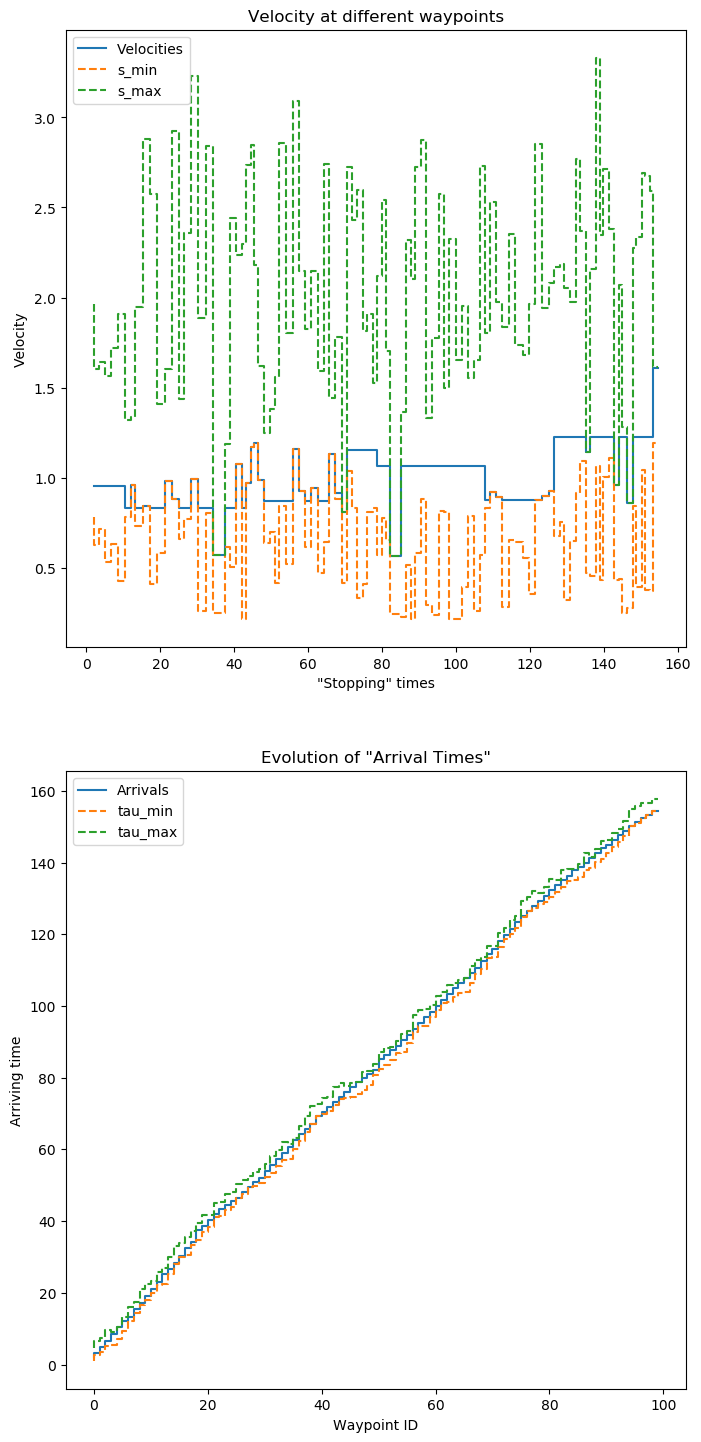

In [101]:

f, (ax1,ax2)= plt.subplots(2,1,figsize=(8,18))

times = ts.value
times=times.reshape(1,n)

timesd=(d/times).reshape(n,1)
times=times.reshape(n,1)


plt_velocities, = ax1.step(A.dot(times),timesd)
plt_smin, = ax1.plot(A.dot(times),s_min,linestyle='--',linewidth=1.5, drawstyle='steps')
plt_smax, = ax1.plot(A.dot(times),s_max,linestyle='--',linewidth=1.5, drawstyle='steps')

ax1.set_title('Velocity at different waypoints')
ax1.set_xlabel('"Stopping" times')
ax1.set_ylabel('Velocity')
ax1.legend([plt_velocities,plt_smin,plt_smax],["Velocities","s_min","s_max"])


plt_arrivings, = ax2.step(np.arange(n),A.dot(times))
plt_taumin, = ax2.plot(np.arange(n),tau_min, linestyle='--',linewidth=1.5, drawstyle='steps')
plt_taumax, = ax2.plot(np.arange(n),tau_max, linestyle='--',linewidth=1.5, drawstyle='steps')
ax2.set_title('Evolution of "Arrival Times"')
ax2.set_xlabel('Waypoint ID')
ax2.set_ylabel('Arriving time')
ax2.legend([plt_arrivings,plt_taumin,plt_taumax],["Arrivals","tau_min","tau_max"])

Convex optimization gives us an opportunity to get better accuracy for less time. We can improve accuracy in dynamic programming by using more dense discretization but this leads to exponential growth of search space and problem can become intractable. In convex optimization, on contrary, the convergence is better (quadratic, if we consider Newton mthod), so all efforts are directed to gradient estimation, which is needed to be done just several times to obtain needed accuracy since the function is positive definite and convex.

On the other hand if the gradient is very small (if coefficients $a_i$ are relatively small) then Newton's method would converge slowly.